# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

from daftpy.daftmodel import split_data, scores_statistics, metrics_regression

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [3]:
sale_data = pd.read_csv('data_available/sale_data_post_out.csv', sep=',')
sale_data.shape  #### cambiar esto

(7387, 34)

In [4]:
features = [
    
    'price',
    'floor_area',
    'views',
    'latitude',
    'longitude',
#    'bedroom',
    'bathroom',
#    'sale_type',
    'type_house',
#    'postcode',
#    'state_district',
#    'county',
#    'city_district',
#    'road',
#    'place',
    'code',
#    'admin1',
#    'cities'
]

data = sale_data[features].copy()
data.shape

(7387, 8)

In [5]:
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
cat_features =  list(data.select_dtypes('object').columns)

num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,type_house
1,views,code
2,latitude,
3,longitude,
4,bathroom,


In [6]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()

cat_feat_df['n_levels'] = [data.type_house.nunique(), data.code.nunique()]
cat_feat_df['sample'] = [levels_type_house, levels_code[:5]]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,type_house,2,"[house, apartment]"
1,code,137,"[D09, T23, F91, V95, R32]"


## Split Data

In [7]:
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=42)

X: (7387, 7)
y: (7387,)


In [8]:
print(X.shape)
X = pd.get_dummies(X).copy() 
print(X.shape)
# podria crear un nuevo parametro en la funcion: with dummies=True

(7387, 7)
(7387, 144)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6278, 144), (1109, 144), (6278,), (1109,))

------------

# Metrics

In [10]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

# Models

## Multiple Linear Regression

En estadística, el **coeficiente de determinación**, denominado R² y pronunciado R cuadrado, es un estadístico usado en el contexto de un modelo estadístico cuyo principal propósito es predecir futuros resultados o probar una hipótesis. El coeficiente determina la calidad del modelo para replicar los resultados, y la proporción de variación de los resultados que puede explicarse por el modelo.

Es el porcentaje de la variación en la variable de respuesta que es explicado por un modelo lineal. Es decir:

R-cuadrado = Variación explicada / variación total

El R-cuadrado siempre está entre 0 y 100%:

https://scikit-learn.org/stable/modules/cross_validation.html

In [11]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
#    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  # No hace nada si ya transformadas
                                      #handle_unknown='ignore'
    ])
# Las transforme antes para evitar problemas no las variables a la hora de predecir e el test_set...

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


lr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', # esto lo puedo agnadir en los otros pipes
                              fill_value=None)),
    ('regressor', LinearRegression())
    ])

In [12]:
X_train.shape

(6278, 144)

In [13]:
scores_lr, scores_resume_lr = scores_statistics(estimator=LinearRegression(), 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=10, 
                                                return_train_score=False)

r2 mean: 0.6593720014812806
r2 std: 0.02893924192753562 

MAE mean: -106485.93603277237
MAE std: 7138.578393317546 

MAPE mean: -0.3159117534748262
MAPE std: 0.021307588371908843 

RMSE mean: -174479.71014816366
RMSE std: 19674.996942601938 



### Evaluating on the Training and Test Sets

We can identify if a machine learning model has overfit by first evaluating the model on the training dataset and then evaluating the same model on a holdout test dataset.

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.

In [17]:
lr = LinearRegression().fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6695416060651669
MAE: 104148.5734134515
MAPE: 0.3077788639546578
RMSE: 172302.5799456458

Performance on the test set:
 ----------
R²: 0.6633324116472135
MAE: 116665.56443551341
MAPE: 0.310476526309548
RMSE: 193194.27298946126



### Learning Curves

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def plot_learning_curves(model, X_train, y_train, X_test, y_test):
 #   X_train, X_val, y_train, y_val = 
    X_val, y_val = X_test.copy(), y_test.copy()
 #   X_train, y_train = X_train[:2500].copy(), y_train[:2500].copy()
    
    train_errors, val_errors = [], []
    for i in range(1, len(X_train)):
        # fit model on the training dataset
        model.fit(X_train[:i], y_train[:i])
        
        y_train_pred = model.predict(X_train[:i])
        y_val_pred = model.predict(X_val)
        
        train_errors.append(mean_absolute_percentage_error(y_train[:i], y_train_pred))
        val_errors.append(mean_absolute_percentage_error(y_val, y_val_pred))
        
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    plt.plot(train_errors, 'r-+', linewidth=2, label='train', alpha=.3)
    plt.plot(val_errors, 'b-', linewidth=3, label='val', alpha=.3)
    ax.set_ylim(0, 1)

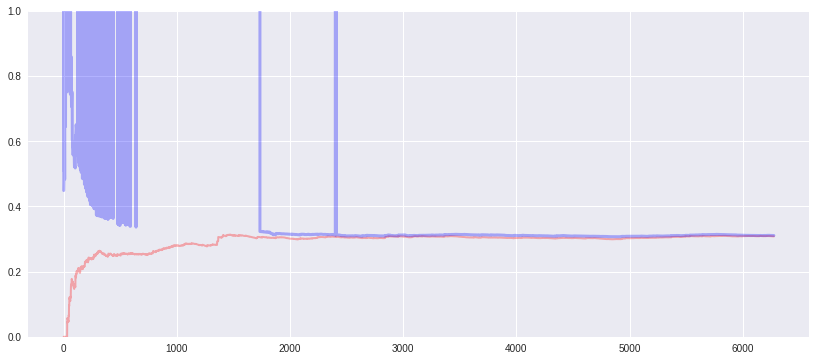

In [22]:
plot_learning_curves(model=LinearRegression(), 
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test)

In [ ]:
sns.regplot(x=y_test, y=lr.predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

-------------

------------

In [ ]:
#joblib.dump(lr, 'models/linear_regression_01-11-2021.plk')

-------------------

## Polynomial Regression

In [ ]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=42)

In [ ]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


poly_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', LinearRegression())
                           ])

In [ ]:
grid_search = GridSearchCV(estimator=estimator, 
                           param_grid={'preprocessor__num__poly__degree': [1,2,3,4,5]}, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
#grid_search.best_estimator_

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
scores = scores_statistics(estimator=poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

In [ ]:
sns.regplot(x=y_test, y=estimator.fit(X_train, y_train).predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

## Decission Tree Regressor

In [ ]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
#    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ])

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[levels_type_house, levels_code]))  #code_levels
                                      #handle_unknown='ignore'
    ])


preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'


dtr_pipe_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', DecisionTreeRegressor())
                           ])

In [ ]:
grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                        #       'preprocessor__num__poly__degree': [1,2,3,4,5],
                               'regressor__max_depth': range(1, 15), #[2,3,4,5,6,7]
                           }, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


In [ ]:
#pd.DataFrame(grid_search.cv_results_)

In [ ]:
sns.regplot(x=y_test, y=dtr_pipe_estimator.fit(X_train, y_train).predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

## Random Forest Regressor

In [ ]:
rfr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', RandomForestRegressor())
                           ])

In [ ]:
param_grid = [
    {'regressor__n_estimators': [3,10,30], 
     'regressor__max_features': range(1, 8)},
    {'regressor__n_estimators': range(41,70)}, #[3,10,30,40,50,60]
]

grid_search = GridSearchCV(estimator=rfr_pipe_est, 
                           param_grid=param_grid,
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
#pd.DataFrame(grid_search.cv_results_).tail()

In [ ]:
rfr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', RandomForestRegressor(n_estimators=45)) # 44, 59, 45
                           ])
#estimator

scores = scores_statistics(estimator=rfr_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

In [ ]:
sns.regplot(x=y_test, y=rfr_pipe_est.fit(X_train, y_train).predict(X_test), 
            scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"})\
           .set_title('Actual vs Predicted');

# K Nearest Neighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

```python
KNeighborsRegressor(n_neighbors=5, 
                    *, 
                    weights='uniform', 
                    algorithm='auto', 
                    leaf_size=30, 
                    p=2, 
                    metric='minkowski', 
                    metric_params=None, 
                    n_jobs=None)
```

In [ ]:
num_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ])

#cat_features = train_set.select_dtypes('object').columns
type_house_levels = train_set.type_house.unique()
code_levels = train_set.code.unique()

cat_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories=[type_house_levels, code_levels]))  #code_levels
                                      #handle_unknown='ignore'
    ])

#num_features = data.select_dtypes('number').columns
#cat_features =  data.select_dtypes('object').columns
num_features = ['floor_area', 
                'views', 
                'latitude', 
                'longitude', 
                'bathroom']
cat_features = ['type_house',
                'code']

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features),
    ]) #, remainder='passthrough'

In [ ]:
knnr_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', KNeighborsRegressor())
                           ])

In [ ]:
param_grid = [
    {
        'regressor__n_neighbors': [5,10,15,20,25,30,35,40,45,50], 
    },
    {
        'preprocessor__num__poly__degree': [1,2,3,4,5],
        'regressor__n_neighbors': [5,10,15,20,25,30,35,40,45,50],
    }, 
]

grid_search = GridSearchCV(estimator=knnr_pipe_est, 
                           param_grid=param_grid,
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)